# AM207 Paper Tutorial: 
## $\textit{Adding Gradient Noise Improves Learning for Very Deep Networks}$ 
## https://arxiv.org/pdf/1511.06807.pdf
## Christopher Hase & Casey Meehan 
## $\texttt{\{christopher\_hase, casey\_meehan\}\@g.harvard.edu}$

# I) Background Information: 

As described in the paper, generalization and noise techniques have been used to advance neural network training for over the last two decades. Those techniques include dropout as well as adding random noise to weights, gradients, and hidden units. 
- (Adaptive) Weight Noise: Weights given the data are understood to have a complex posterior distribution. To make the complex posterior tractable, a variational posterior is used and weights are sampled iteratively. 
 - See https://www.cs.toronto.edu/~graves/nips_2011_poster.pdf
- Dropout: Randomly drop entire units (and thus connections) from the network during training time. This produces a number of 'thinned' networks whose average output is approximated by an unthinned network with lower magnitude weights.
 - See https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
 
The following are some of the main benefits of neural network generalization and noise techniques: 

 - 1) Lower likelihood of loss getting stuck at a 'bad' local minimum
 
 - 2) Loss convergence to a 'good' local minimum in fewer iterations
 
 - 3) Reduction of overfitting


# II) Summary of Relevant Methods: 

In this paper, the authors' advance document the effectiveness of gradient noise techniques by using a declining temperature schedule for the noise as in simulated annealing to improve convergence of the network. 

The technique is simple: zero-mean normally-distributed noise is added to the network gradient to produce a modified network gradient that is used to update the weights at each step of stochastic gradient descent. Let the $\mathbf{w}$ represent the network weights, $\mathcal{D}$ represent a batch of training datapoints, $\mathcal{L}$ represent the network loss function, $\epsilon$ represent the noise term, $t$ represent the training step count, and $\alpha$ represent the learning rate. Then the method is as follows:

$$
\widetilde{\nabla}_{\mathbf{w}}\mathcal{L}(\mathcal{D})_t = \nabla_{\mathbf{w}}\mathcal{L}(\mathcal{D})_t + \epsilon_t
$$

where

$$
\epsilon_t \sim \mathcal{N}(0, \sigma_t^2)
$$

Then we update the weights via stochastic gradient descent as follows: 

$$
\mathbf{w}_{t+1} = \mathbf{w}_t - \alpha\cdot\widetilde{\nabla}_{\mathbf{w}} \mathcal{L}(\mathcal{D})_t
$$

An important finding in the paper is the beneficial effect of decreasing the gradient noise over training steps by using a declining temperature schedule for the variance of the Gaussian noise: 

$$
\sigma^2_t = \frac{\eta}{(1+t)^\gamma}
$$

As the authors describe, this helps jump-start the training process by having high variance noise during early iterations. As noise variance declines towards 0, network accuracy can be tuned. In the paper, the authors experiment with $\eta = \{0.01, 0.3, 1.0\}$ and use $\gamma = 0.55$. However, in this tutorial we experiment with a wider range of values.

# III) Implementation and Results

Here we're importing in the necessary libraries. This tutorial will be using PyTorch for implementing the deep neural network with noisy gradients.

In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn.metrics
import torch
import torchvision
from torch.autograd import Variable

At the top of this cell are helper functions for dividing the MNIST dataset into train, validation, and test sets. Following the helper functions, we divide the MNIST data into train, validation, and test sets as well as create batches for each of those data subsets. As you can see, we use batches of size 256. Note that the authors of the paper use the MNIST dataset for some of their experiments.

In [3]:
# functions/classes taken from: https://gist.github.com/t-vi/9f6118ff84867e89f3348707c7a1271f
# to help create validation set
class PartialDataset(torch.utils.data.Dataset):
    def __init__(self, parent_ds, offset, length):
        self.parent_ds = parent_ds
        self.offset = offset
        self.length = length
        assert len(parent_ds)>=offset+length, Exception("Parent Dataset not long enough")
        super(PartialDataset, self).__init__()
    def __len__(self):
        return self.length
    def __getitem__(self, i):
        return self.parent_ds[i+self.offset]

def validation_split(dataset, val_share=0.1):
    """
       Split a (training and vaidation combined) dataset into training and validation.
       Note that to be statistically sound, the items in the dataset should be statistically
       independent (e.g. not sorted by class, not several instances of the same dataset that
       could end up in either set).
    
       inputs:
          dataset:   ("training") dataset to split into training and validation
          val_share: fraction of validation data (should be 0<val_share<1, default: 0.1)
       returns: input dataset split into test_ds, val_ds
       
       """
    val_offset = int(len(dataset)*(1-val_share))
    return PartialDataset(dataset, 0, val_offset), PartialDataset(dataset, val_offset, len(dataset)-val_offset)


torch.manual_seed(1)

# load in MNIST and create train, validation, and test sets
train_validation = torchvision.datasets.MNIST(root = os.getcwd(),
                   train=True, transform=torchvision.transforms.ToTensor(), download = True)
train, validation = validation_split(train_validation, 1/6) # get train/validation split
test = torchvision.datasets.MNIST(root = os.getcwd(), train=False, 
       transform=torchvision.transforms.ToTensor(), download = True)

# create batches for train, validation, and test sets
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(dataset = validation, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle = False)

Here is our deep feed-forward neural network architecture. We use 12 hidden layers and ReLU activation functions. There are 10 outputs, one for each digit. Note that the authors of the reference paper use 20 hidden layers and ReLU activation functions for some of their networks, but we use 12 in order to save time. We also assume that a GPU is available to the user.

In [4]:
# Deep NN architecture
# 12 layers, ReLU activations functions
class Deep_FFNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Deep_FFNN, self).__init__()
        
        self.linear1 = torch.nn.Linear(in_features = input_size,
                       out_features = hidden_size, bias = True).cuda()
        self.relu1 = torch.nn.ReLU().cuda()
        self.linear2 = torch.nn.Linear(in_features = hidden_size, 
                       out_features = hidden_size, bias = True).cuda()
        self.relu2 = torch.nn.ReLU().cuda()
        self.linear3 = torch.nn.Linear(in_features = hidden_size, 
                       out_features = hidden_size, bias = True).cuda()
        self.relu3 = torch.nn.ReLU().cuda()
        self.linear4 = torch.nn.Linear(in_features = hidden_size, 
                       out_features = hidden_size, bias = True).cuda()
        self.relu4 = torch.nn.ReLU().cuda()
        self.linear5 = torch.nn.Linear(in_features = hidden_size, 
                       out_features = hidden_size, bias = True).cuda()
        self.relu5 = torch.nn.ReLU().cuda()
        self.linear6 = torch.nn.Linear(in_features = hidden_size, 
                       out_features = hidden_size, bias = True).cuda()
        self.relu6 = torch.nn.ReLU().cuda()
        self.linear7 = torch.nn.Linear(in_features = hidden_size, 
                       out_features = hidden_size, bias = True).cuda()
        self.relu7 = torch.nn.ReLU().cuda()
        self.linear8 = torch.nn.Linear(in_features = hidden_size, 
                       out_features = hidden_size, bias = True).cuda()
        self.relu8 = torch.nn.ReLU().cuda()
        self.linear9 = torch.nn.Linear(in_features = hidden_size, 
                       out_features = hidden_size, bias = True).cuda()
        self.relu9 = torch.nn.ReLU().cuda()
        self.linear10 = torch.nn.Linear(in_features = hidden_size, 
                        out_features = hidden_size, bias = True).cuda()
        self.relu10 = torch.nn.ReLU().cuda()
        self.linear11 = torch.nn.Linear(in_features = hidden_size, 
                        out_features = hidden_size, bias = True).cuda()
        self.relu11 = torch.nn.ReLU().cuda()
        self.linear12 = torch.nn.Linear(in_features = hidden_size,
                        out_features = hidden_size, bias = True).cuda()
        self.relu12 = torch.nn.ReLU().cuda()
        self.linearOut = torch.nn.Linear(in_features = hidden_size, out_features = 10, 
                                         bias = True).cuda()
        
    def forward(self, input):
        hidden = self.linear1(input)
        hidden = self.relu1(hidden)
        hidden = self.linear2(hidden)
        hidden = self.relu2(hidden)
        hidden = self.linear3(hidden)
        hidden = self.relu3(hidden)
        hidden = self.linear4(hidden)
        hidden = self.relu4(hidden)
        hidden = self.linear5(hidden)
        hidden = self.relu5(hidden)
        hidden = self.linear6(hidden)
        hidden = self.relu6(hidden)
        hidden = self.linear7(hidden)
        hidden = self.relu7(hidden)
        hidden = self.linear8(hidden)
        hidden = self.relu8(hidden)
        hidden = self.linear9(hidden)
        hidden = self.relu9(hidden)
        hidden = self.linear10(hidden)
        hidden = self.relu10(hidden)
        hidden = self.linear11(hidden)
        hidden = self.relu11(hidden)
        hidden = self.linear12(hidden)
        hidden = self.relu12(hidden)
        output = self.linearOut(hidden)

        return output

This cell contains a function for computing the accuracy of a model. The prediction is the digit for which the model outputs the highest probability.

In [5]:
# function for computing accuracy
def compute_accuracy(data_loader, model, input_size):
    model_pred = []
    targets = []
    softmax = torch.nn.Softmax() # softmax to compute output probabilities 
    for batch in data_loader:
        model_output = model(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), 
                                      input_size)).cuda()) # output from NN
        model_probs = softmax(model_output).cpu().data.numpy() # digit probabilities
        model_pred += np.argmax(model_probs, axis = 1).tolist() # digit predictions
        targets += batch[1].numpy().tolist() # true digit values
        
    return sklearn.metrics.accuracy_score(targets, model_pred)

Here are the training parameters, model hyper-parameters, and the loss function. As you can see, we train for 70 epochs and minimize cross-entropy loss. We set hidden layer sizes to be 50 as in the reference paper and regularization parameter $\lambda=0.000001$. The learning rate $\alpha$ is selected from $\{0.1, 0.01\}$, $\eta$ is selected from $\{0.00001,0.0001, 0.001, 0.01\}$, and $\gamma$ is selected from $\{0.1, 0.3,0.5,0.7,0.9\}$. Recall the way in which we add Gaussian noise to the gradient with respect to the parameters for each training update: 

$$
\widetilde{\nabla}_{\mathbf{w}}\mathcal{L}(\mathcal{D})_t = \nabla_{\mathbf{w}}\mathcal{L}(\mathcal{D})_t+\mathcal{N}(0,\sigma_t^2)
$$
where 
$$
\sigma_t^2=\dfrac{\eta}{(1+t)^\gamma} 
$$

In [6]:
# hyperparameters to try
lrs = [0.1, 0.01]
etas = [0.00001, 0.0001, 0.001, 0.01]
gammas = [0.1, 0.3, 0.5, 0.7, 0.9]

input_size = 28*28 # mnist image sizes
lam = 0.000001
hidden_size = 50

num_epochs = 70
loss_function = torch.nn.CrossEntropyLoss() # cross entropy loss function

Here is a plot showing the schedule of $\sigma_t^2$ over the beginning of the training period under some combinations of $\eta$ and $\gamma$. When $\gamma$ is low, $\sigma_t^2$ decreases at a lower rate. When $\eta$ is low, $\sigma_t^2$ starts at a lower value.

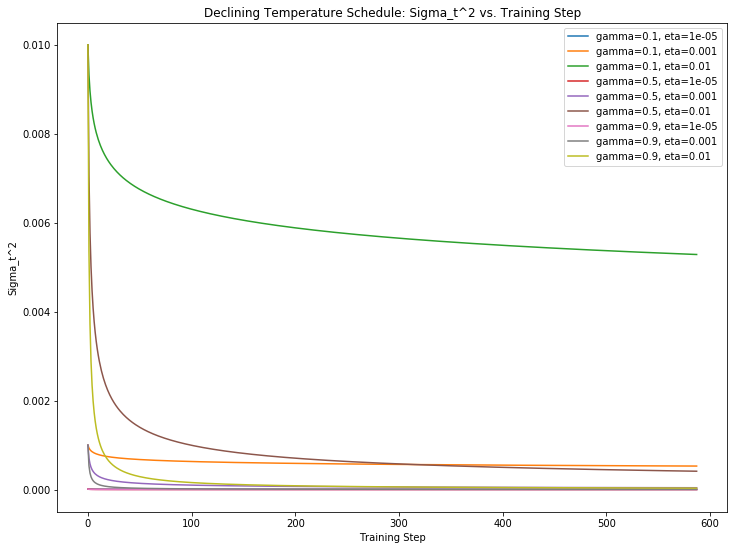

In [7]:
etas_for_plot = [0.00001, 0.001, 0.01]
gammas_for_plot = [0.1, 0.5, 0.9]
num_epochs_plot = 3

plt.figure(figsize = (12,9))
for gamma in gammas_for_plot:
    for eta in etas_for_plot:
        sigma_t2_list = []
        for t in range(len(train_loader) * num_epochs_plot):
            sigma_t2 = eta/((1 + t)**gamma)
            sigma_t2_list.append(sigma_t2)
        plt.plot(np.arange(t+1), sigma_t2_list)
plt.legend(loc = 'upper right', labels = ['gamma=' + str(gamma)
           + ', eta=' + str(eta) for gamma in gammas_for_plot for eta in etas_for_plot])
plt.xlabel('Training Step')
plt.ylabel('Sigma_t^2')
plt.title('Declining Temperature Schedule: Sigma_t^2 vs. Training Step')
plt.show()

Here is the code for training, validating, and testing the deep feed-forward neural network when adding gradient noise. We choose the model whereby the corresponding hyper-parameters resulted in highest classification accuracy on the validation set and then compute the accuracy of the chosen model on the test set. As you can see, we add Gaussian noise to the gradient with respect to each of the parameters and update $\sigma_t^2$ at each training step. The comments should be helpful for understanding the code.

In [7]:
### noise used in gradients
torch.manual_seed(1)

# loop through hyperparams
best_val_acc = 0
for lr in lrs:
    for gamma in gammas:
        for eta in etas:

            # instantiate model
            deep_FFNN = Deep_FFNN(input_size, hidden_size)

            # SGD optimizer
            optimizer = torch.optim.SGD(deep_FFNN.parameters(), lr, weight_decay = lam)

            # count number of training steps
            t = 0
            for epoch in range(num_epochs):   
                for batch in train_loader:
                    model_output = deep_FFNN(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), 
                                                      input_size)).cuda()) # output from NN
                    targets = Variable(batch[1]).cuda() # true digit values

                    optimizer.zero_grad() # zero gradient
                    loss_batch = loss_function(model_output, targets) # compute loss
                    loss_batch.backward() # take the gradient wrt parameters
                        
                    sigma_t = np.sqrt(eta/((1 + t)**gamma)) # sigma_t for noise
                    noise = torch.normal(means = torch.zeros(1),
                            std = torch.ones(1) * sigma_t).numpy()[0].astype(np.float64) # get noise value

                    for param in list(deep_FFNN.parameters()):
                        param.grad += noise # add noise to gradient with respect to parameter
                            
                    optimizer.step() # update parameters
                    t += 1 # add to count of training steps
                                    
            # compute accuracy on validation set
            val_acc = compute_accuracy(validation_loader, deep_FFNN, input_size)
            print('Validation accuracy for gamma=' + str(gamma) + ', learning rate=' + str(lr) 
                  + ', eta=' + str(eta) + ': ' + str(val_acc))
                
            # save best model and best model hyperparams
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_lr = lr
                best_gamma = gamma
                best_eta = eta
                best_model = deep_FFNN

# compute accuracy on test set
test_acc = compute_accuracy(test_loader, best_model, input_size)
print('Test accuracy for gamma=' + str(best_gamma) + ', learning rate=' + str(best_lr) 
      + ', eta=' + str(best_eta) + ': ' + str(test_acc))

Validation accuracy for gamma=0.1, learning rate=0.1, eta=1e-05: 0.4057
Validation accuracy for gamma=0.1, learning rate=0.1, eta=0.0001: 0.9233
Validation accuracy for gamma=0.1, learning rate=0.1, eta=0.001: 0.1064
Validation accuracy for gamma=0.1, learning rate=0.1, eta=0.01: 0.1064
Validation accuracy for gamma=0.3, learning rate=0.1, eta=1e-05: 0.1064
Validation accuracy for gamma=0.3, learning rate=0.1, eta=0.0001: 0.963
Validation accuracy for gamma=0.3, learning rate=0.1, eta=0.001: 0.1064
Validation accuracy for gamma=0.3, learning rate=0.1, eta=0.01: 0.1064
Validation accuracy for gamma=0.5, learning rate=0.1, eta=1e-05: 0.1064
Validation accuracy for gamma=0.5, learning rate=0.1, eta=0.0001: 0.1064
Validation accuracy for gamma=0.5, learning rate=0.1, eta=0.001: 0.9354
Validation accuracy for gamma=0.5, learning rate=0.1, eta=0.01: 0.1064
Validation accuracy for gamma=0.7, learning rate=0.1, eta=1e-05: 0.1064
Validation accuracy for gamma=0.7, learning rate=0.1, eta=0.0001:

Here is the code for training, validating, and testing the deep feed-forward neural network when not adding gradient noise. We choose the model whereby the corresponding learning rate resulted in the highest classification accuracy on the validation set and then computed the accuracy of the chosen model on the test set. Having this allows us to compare methods (gradient noise vs. no gradient noise).

In [10]:
### no noise used in gradients
torch.manual_seed(1)

# loop through hyperparams
best_val_acc = 0
for lr in lrs:
    
    # instantiate model
    deep_FFNN = Deep_FFNN(input_size, hidden_size)
    
    # SGD optimizer
    optimizer = torch.optim.SGD(deep_FFNN.parameters(), lr, weight_decay = lam)

    for epoch in range(num_epochs):   
        for batch in train_loader:
            model_output = deep_FFNN(Variable(torch.squeeze(batch[0], 1).view(len(batch[0]), 
                                              input_size)).cuda()) # model predictions
            targets = Variable(batch[1]).cuda() # true digit values

            optimizer.zero_grad() # zero gradient
            loss_batch = loss_function(model_output, targets) # compute loss
            loss_batch.backward() # take the gradient wrt parameters
            optimizer.step() # update parameters
                        
                
    # compute accuracy on validation set
    val_acc = compute_accuracy(validation_loader, deep_FFNN, input_size)
    print('Validation accuracy for learning rate=' + str(lr) + ': ' + str(val_acc))
            
    # save best model and best model hyperparams
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_lr = lr
        best_model = deep_FFNN

# compute accuracy on test set
test_acc = compute_accuracy(test_loader, best_model, input_size)
print('Test accuracy for learning rate=' + str(lr) + ': ' + str(test_acc))

Validation accuracy for learning rate=0.1: 0.1064
Validation accuracy for learning rate=0.01: 0.1064
Test accuracy for learning rate=0.01: 0.1135


# IV) Discussion of Results

The test accuracy that we see from the best network when using gradient noise is much higher than that which we see from the best network when not using gradient noise. The network trained with gradient noise using $\alpha=0.1$, $\gamma=0.3$, and $\eta=0.0001$ achieved a very high test accuracy of $0.9618$. This is consistent with the best accuracies seen in the paper for networks trained with gradient noise. In contrast, the networks trained without gradient noise must have had losses that got stuck at local minima! The network trained with $\alpha=0.01$ achieved a test accuracy of only $0.1135$. This is a much worse result than the best accuracies seen in the paper for networks trained without gradient noise. 

Note that the authors of the paper trained networks many times for each method (noise or no noise) and reported the average test accuracy and maximum test accuracy across all trained networks for each method. In some cases, the average test accuracy was much lower than the maximum test accuracy, indicating that only some networks within the set of trained networks trained well. In other words, holding method and hyper-parameters fixed, with some probability a network trained well and with some probability it did not. Because of the amount of time it takes to train a network on our laptops, we only trained the tuned network for each method once and reported the test accuracies. This is a major caveat when comparing our results to those seen in the paper. Had we trained the networks many times, it is entirely possible that our results would be consistent with the average and maximum test accuracies for each method from the paper. However, it is promising for the technique of using gradient noise that the tuned network trained with gradient noise achieved such a high test accuracy and the networks trained without gradient noise trained poorly.

The validation accuracies from tuning the network trained with gradient noise indicate that the training is highly sensitive to the hyper-parameters governing the declining temperature schedule. However, these results should be interpreted with caution since for each hyper-parameter combination we only trained one network. Future research should include a more thorough comparison of the results from varying declining temperature schedules.